In [ ]:
! pip install tensorflow pandas numpy scikit-learn spacy matplotlib seaborn

In [5]:
! python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
input = "input/1661-0.txt"

with open(input, 'r', encoding='utf-8') as infile:
    data = infile.read() 

In [7]:
print(f'number of words : {len(data.split("\n"))}')
print(f'number of chars : {len(data)}')

number of words : 12311
number of chars : 581888


In [8]:
data = data[-200000:]

In [9]:
print(f'number of words : {len(data.split("\n"))}')
print(f'number of chars : {len(data)}')

number of words : 4149
number of chars : 200000


In [10]:
import re
import spacy 
nlp = spacy.load("en_core_web_sm")
def preprocess(text):
    preprocessed_sents = []
    text = text.replace('\n',' ')
    doc = nlp(text) 
    for sent in doc.sents: 
        sent = sent.text
        sent = re.sub(r'[^a-zA-Z0-9.,!? ]', '', sent.lower())  
        sent = re.sub(r'\s+', ' ', sent).strip()
        if len(sent.split(" ")) <= 2 or len(sent.split(" ")) > 20:
            continue
        preprocessed_sents.append(sent)
    return preprocessed_sents
    

In [11]:
sentences = preprocess(data)
sentences[:10]

['do you promise, then? said he at last.',
 'yes, i promise.',
 'absolute and complete silence before, during, and after?',
 'no reference to the matter at all, either in word or writing?',
 'i have already given you my word.',
 'he suddenly sprang up, and darting like lightning across the room he flung open the door.',
 'the passage outside was empty.',
 'thats all right, said he, coming back.',
 'i know that clerks are sometimes curious as to their masters affairs.',
 'now we can talk in safety.']

In [ ]:
len(sentences)

1389

Tokenize texts into unique Ids

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1
total_words


2620

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)
len(sequences)

1389

In [ ]:
len(sequences[0]) #number of token in the first text 

8

In [ ]:
seq = [2,4,5,1,4]

for i in range(2,len(seq)+1):
    print(seq[:i])

[2, 4]
[2, 4, 5]
[2, 4, 5, 1]
[2, 4, 5, 1, 4]


Create Ngram sequences

In [ ]:
MAX_SEQ_LENGTH = max(len(sequence) for sequence in sequences)
MAX_SEQ_LENGTH

20

In [ ]:
ngram_tokens = []
for sequence in sequences:
    for i in range(1, len(sequence)+1):
        ngram_tokens.append(sequence[:i])

In [ ]:
len(ngram_tokens)

15118

Add Padding 

In [ ]:
import numpy as np 
from tensorflow.keras.preprocessing.sequence import pad_sequences

input_sequences = np.array(pad_sequences(ngram_tokens, maxlen=MAX_SEQ_LENGTH, padding='pre'))
input_sequences[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 35], dtype=int32)

Split into inputs/outputs

In [ ]:
X = input_sequences[:, :-1]
labels = input_sequences[:, -1]

Label One Hot Encoding

In [ ]:
import tensorflow as tf

y = tf.keras.utils.to_categorical(labels, num_classes=total_words)
len(y[0])

2620

In [ ]:
len(input_sequences)

15118

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import numpy as np

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(12094, 19)
(12094, 2620)
(3024, 19)
(3024, 2620)


In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(total_words, 100)) 
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=1)

E0000 00:00:1748239555.112917  512532 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748239555.126991  512532 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.0514 - loss: 6.4780 - val_accuracy: 0.0995 - val_loss: 5.9542
Epoch 2/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1168 - loss: 5.2914 - val_accuracy: 0.1154 - val_loss: 5.9781
Epoch 3/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1585 - loss: 4.5103 - val_accuracy: 0.1147 - val_loss: 6.2157
Epoch 4/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2252 - loss: 3.7513 - val_accuracy: 0.1224 - val_loss: 6.5030
Epoch 5/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3099 - loss: 3.0985 - val_accuracy: 0.1065 - val_loss: 6.9275
Epoch 6/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4093 - loss: 2.5918 - val_accuracy: 0.1045 - val_loss: 7.2870
Epoch 7/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4886 - loss: 2.1578 - val_accuracy: 0.1058 - val_loss: 7.6872
Epoch 8/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5546 - loss: 1.8572 - val_accu

In [ ]:
model.save("prediction_model.h5") 

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model("prediction_model.h5")  

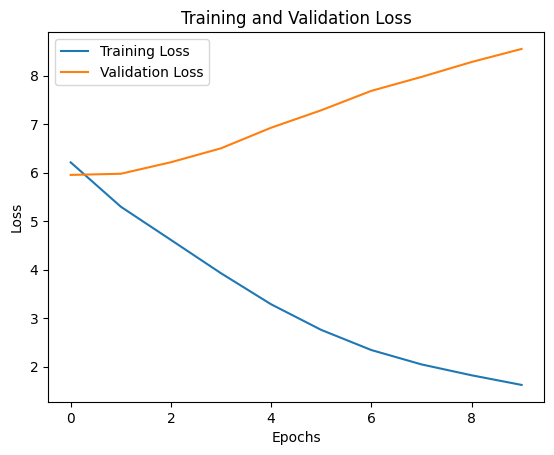

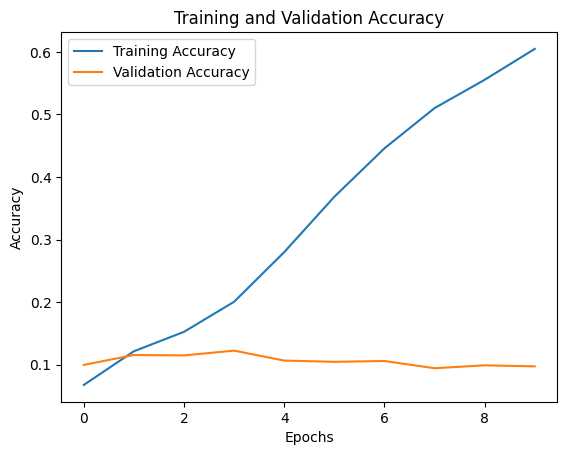

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
def predict_top_five_words(model, tokenizer, seed_text, max_seq_length=None):
  
    try:
        token_list = tokenizer.texts_to_sequences([seed_text])
        if not token_list or len(token_list[0]) == 0:
            return ["<no_valid_tokens>"]
            
        token_list = token_list[0]
        
        if max_seq_length is None:
            max_seq_length = MAX_SEQ_LENGTH - 1 if 'MAX_SEQ_LENGTH' in globals() else len(token_list)
            
        token_list = pad_sequences([token_list], maxlen=max_seq_length, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        top_indices = np.argsort(predicted[0])[::-1][:5]
        reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
        top_words = [reverse_word_index.get(idx, '<unknown>') for idx in top_indices]
        
        return top_words
        
    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return ["<prediction_error>"]

In [ ]:
seed_text = "i think this is "
predict_top_five_words(loaded_model, tokenizer, seed_text)

['in', 'my', 'a', 'up', 'about']